# 04 — Inference 2025 (Window 1–10) + Timeseries (inline)

Tujuan:
1) Load **pipeline terbaik** dari `artefacts_2024_window_full/` (hasil Notebook 03).
2) Prediksi sentimen untuk **2025 window (clean)** → simpan ke CSV.
3) Agregasi bulanan → **tampilkan** plot timeseries di notebook + simpan tabel CSV.



In [1]:
%%time
# (Opsional tapi dianjurkan) Batasi thread BLAS demi stabilitas
import os
os.environ["OMP_NUM_THREADS"]="1"
os.environ["OPENBLAS_NUM_THREADS"]="1"
os.environ["MKL_NUM_THREADS"]="1"
os.environ["NUMEXPR_NUM_THREADS"]="1"
os.environ["VECLIB_MAXIMUM_THREADS"]="1" 
print("Thread limits set.")


Thread limits set.
CPU times: total: 0 ns
Wall time: 393 μs


## 1) Path & konfigurasi dasar


In [2]:
%%time
from pathlib import Path

ARTEFACT_DIR = Path("artefacts_2024_window_full")
INPUT_2025   = Path("reddit_opinion_PSE_ISR_2025_window_clean.csv")

# Output
PRED_CSV = Path("reddit_opinion_PSE_ISR_2025_window_pred.csv")
TS_COUNT = Path("sentiment_timeseries_2025_count.csv")
TS_SHARE = Path("sentiment_timeseries_2025_share.csv")

# Plot hanya TAMPIL di notebook; simpan PNG -> False (bisa ubah ke True jika ingin file)
SAVE_PNG  = False
PLOT_PNG  = Path("sentiment_timeseries_2025.png")

ALL_LABELS = ["Positif", "Netral", "Negatif"]

assert ARTEFACT_DIR.exists(), "Folder artefak tidak ada."
assert INPUT_2025.exists(),   "File 2025 window_clean tidak ditemukan."
print("✅ Paths OK")


✅ Paths OK
CPU times: total: 0 ns
Wall time: 747 μs


## 2) Pilih & muat model terbaik (mengacu artefak Notebook 03)
Prioritas:
1) `model_meta.json` → kunci `best_pipeline`.
2) Jika tidak ada, `cv_results_2024_window.json` → skor tertinggi.
3) Fallback: `best_tfidf_svm.joblib` bila tersedia.


In [3]:
%%time
import json, joblib

NAME2FILE = {
    "tfidf_nb":    "best_tfidf_nb.joblib",
    "tfidf_svm":   "best_tfidf_svm.joblib",
    "tfidf_lr":    "best_tfidf_lr.joblib",
    "count_nb":    "best_count_nb.joblib",
    "count_svm":   "best_count_svm.joblib",
    "count_lr":    "best_count_lr.joblib",
    "stack_tfidf": "best_stack_tfidf.joblib",
    "stack_count": "best_stack_count.joblib",
}

def pick_best_model_path(arte_dir: Path):
    best_name = None
    meta = {}

    meta_path = arte_dir / "model_meta.json"
    if meta_path.exists():
        try:
            meta = json.load(open(meta_path, "r", encoding="utf-8"))
            best_name = meta.get("best_pipeline")
        except Exception:
            pass

    if best_name is None:
        cv_path = arte_dir / "cv_results_2024_window.json"
        if cv_path.exists():
            try:
                cv = json.load(open(cv_path, "r", encoding="utf-8"))
                best_name = max(cv, key=lambda d: d["best_score"])["name"]
                meta = {"best_pipeline": best_name,
                        "best_cv": max(d["best_score"] for d in cv)}
            except Exception:
                pass

    if best_name is None:
        # fallback konservatif berdasar file yang ada
        for f in ["best_tfidf_svm.joblib", "best_stack_tfidf.joblib",
                  "best_tfidf_lr.joblib", "best_tfidf_nb.joblib"]:
            if (arte_dir / f).exists():
                # turunkan nama dari file
                inv = {v:k for k,v in NAME2FILE.items()}
                best_name = inv.get(f, "tfidf_svm")
                break

    assert best_name is not None, "Tidak bisa menentukan best pipeline."
    model_file = NAME2FILE[best_name]
    model_path = arte_dir / model_file
    assert model_path.exists(), f"Model file tidak ditemukan: {model_path}"

    return best_name, model_path, meta

best_name, model_path, meta = pick_best_model_path(ARTEFACT_DIR)
pipe = joblib.load(model_path)
print(f"🏆 Best pipeline: {best_name}")
print(f"📦 Loaded: {model_path.name}")
if meta: print("ℹ️ meta:", meta)


🏆 Best pipeline: stack_count
📦 Loaded: best_stack_count.joblib
ℹ️ meta: {'best_pipeline': 'stack_count', 'best_cv': 0.9485716179500046, 'train_months': ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10'], 'test_months': ['2024-11', '2024-12'], 'test_accuracy': 0.9528495095548267, 'test_macro_f1': 0.9525158564642581, 'labels': ['Positif', 'Netral', 'Negatif'], 'text_column_used': 'final_text', 'vectorizer': 'CountVectorizer', 'supports_predict_proba': True, 'source_file': 'reddit_opinion_PSE_ISR_2024_window_labeled_textblob.csv', 'search_results': [{'name': 'tfidf_nb', 'best_score': 0.7888237881291467, 'best_params': {'vect__ngram_range': [1, 1], 'vect__min_df': 5, 'vect__max_df': 0.9, 'clf__alpha': 2.0}, 'elapsed_sec': 97.98}, {'name': 'tfidf_svm', 'best_score': 0.9295178975558676, 'best_params': {'vect__sublinear_tf': False, 'vect__ngram_range': [1, 1], 'vect__min_df': 10, 'vect__max_df': 0.85, 'clf__max_iter': 5000, 'clf__cla

## 3) Load data 2025 (clean) & sanity check
- Wajib ada kolom `final_text`.  
- `month` idealnya sudah ada (dibuat saat preprocessing window). Jika tidak, diturunkan dari `created_time`.


In [4]:
%%time
import pandas as pd
import numpy as np

df = pd.read_csv(INPUT_2025, low_memory=False)
need_text = "final_text" if "final_text" in df.columns else "self_text"
assert need_text in df.columns, "Kolom final_text/self_text tidak ada."

if "month" not in df.columns:
    assert "created_time" in df.columns, "Perlu 'month' atau 'created_time'."
    dt = pd.to_datetime(df["created_time"], errors="coerce")
    df = df[dt.notna()].copy()
    df["month"] = dt.dt.to_period("M").astype(str)

print("Sample kolom:", df.columns.tolist()[:10])
df[[need_text, "month"]].head(3)


Sample kolom: ['comment_id', 'created_time', 'self_text', 'score', 'subreddit', 'final_text', 'month']
CPU times: total: 2.64 s
Wall time: 2.71 s


,final_text,month
0,old stuff alreadi discuss ad nauseam two year ...,2025-09
1,may stop send iranian drone reason israel atta...,2025-09
2,googl found page brin larri page michigan serg...,2025-09


## 4) Prediksi (inline)
- Jika pipeline punya `predict_proba` → simpan probabilitas per label.  
- Jika tidak (mis. LinearSVC) → simpan `score_margin` dari `decision_function`.


In [5]:
%%time
supports_proba = hasattr(pipe, "predict_proba")
supports_df    = hasattr(pipe, "decision_function")

texts = df[need_text].astype(str).values
pred  = pipe.predict(texts)

out = df.copy()
out["pred_label"] = pred

if supports_proba:
    try:
        proba = pipe.predict_proba(texts)
        classes_ = list(getattr(pipe, "classes_", []))
        if not classes_ and hasattr(pipe[-1], "classes_"):
            classes_ = list(pipe[-1].classes_)
        proba_df = pd.DataFrame(proba, columns=[f"proba_{c.lower()}" for c in classes_])
        for c in ["Positif","Netral","Negatif"]:
            cn = f"proba_{c.lower()}"
            if cn not in proba_df.columns:
                proba_df[cn] = 0.0
        proba_df = proba_df[[f"proba_{c.lower()}" for c in ["Positif","Netral","Negatif"]]]
        out = pd.concat([out.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)
    except Exception as e:
        print("⚠️ predict_proba gagal:", e)
        out["score_margin"] = np.nan
elif supports_df:
    try:
        margin = pipe.decision_function(texts)
        if isinstance(margin, np.ndarray) and margin.ndim == 2:
            out["score_margin"] = margin.max(axis=1) - margin.min(axis=1)
        else:
            out["score_margin"] = margin
    except Exception as e:
        print("⚠️ decision_function gagal:", e)
        out["score_margin"] = np.nan
else:
    out["score_margin"] = np.nan

print("Preview prediksi:")
out[[need_text, "pred_label"]].head(5)


Preview prediksi:
CPU times: total: 10.2 s
Wall time: 10.3 s


,final_text,pred_label
0,old stuff alreadi discuss ad nauseam two year ...,Netral
1,may stop send iranian drone reason israel atta...,Netral
2,googl found page brin larri page michigan serg...,Positif
3,differ appear qatari knew allow proceed canadi...,Netral
4,take look video instagram damag small video cl...,Netral


## 5) Simpan hasil prediksi (CSV)


In [6]:
%%time
out.to_csv(PRED_CSV, index=False)
print("✅ Saved:", PRED_CSV.resolve())


✅ Saved: D:\Machine Learning\Israel-Iran Sentiment Analysis - Copy\reddit_opinion_PSE_ISR_2025_window_pred.csv
CPU times: total: 2.44 s
Wall time: 2.45 s


## 6) Timeseries agregasi (count & share) — tampilkan di notebook


In [7]:
%%time
# pastikan tipe string
out["month"] = out["month"].astype(str)

ts_count = (
    out.groupby(["month","pred_label"])
       .size()
       .reset_index(name="count")
       .pivot(index="month", columns="pred_label", values="count")
       .fillna(0)
       .astype(int)
       .reindex(columns=ALL_LABELS, fill_value=0)
       .sort_index()
)
ts_share = ts_count.div(ts_count.sum(axis=1), axis=0).fillna(0)

ts_count.to_csv(TS_COUNT)
ts_share.to_csv(TS_SHARE)

print("✅ Saved tables:")
print(" -", TS_COUNT.resolve())
print(" -", TS_SHARE.resolve())

print("\nCount (tail):")
display(ts_count.tail(5))
print("Share (tail):")
display(ts_share.tail(5))


✅ Saved tables:
 - D:\Machine Learning\Israel-Iran Sentiment Analysis - Copy\sentiment_timeseries_2025_count.csv
 - D:\Machine Learning\Israel-Iran Sentiment Analysis - Copy\sentiment_timeseries_2025_share.csv

Count (tail):


pred_label,Positif,Netral,Negatif
month,,,
2025-05,11235,14754,7585
2025-06,14816,18950,10153
2025-07,11903,16080,8883
2025-08,14865,19750,10545
2025-09,13966,19224,9581


Share (tail):


pred_label,Positif,Netral,Negatif
month,,,
2025-05,0.334634,0.439447,0.225919
2025-06,0.337348,0.431476,0.231176
2025-07,0.322872,0.436174,0.240954
2025-08,0.329163,0.437334,0.233503
2025-09,0.326530,0.449463,0.224007


CPU times: total: 62.5 ms
Wall time: 62.7 ms


## 7) Plot timeseries (inline only)


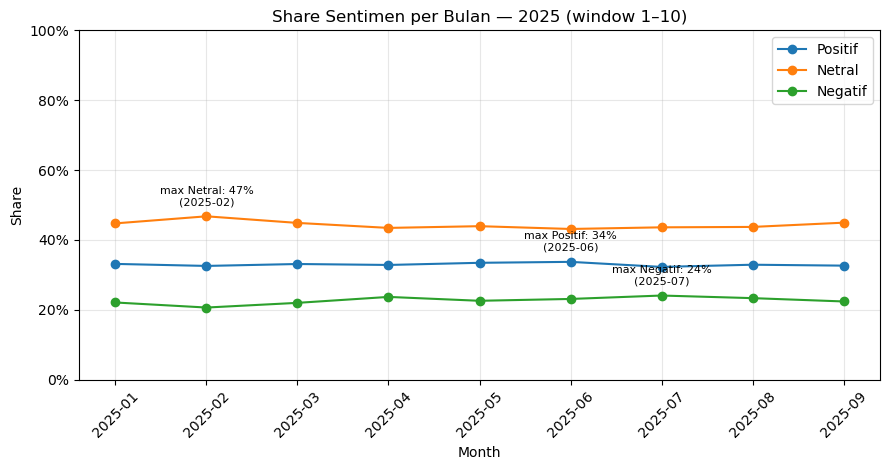

CPU times: total: 188 ms
Wall time: 193 ms


In [10]:
%%time
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

ts = ts_share.reindex(sorted(ts_share.index))
labs = [c for c in ["Positif","Netral","Negatif"] if c in ts.columns]

fig, ax = plt.subplots(figsize=(9,4.8))
for lab in labs:
    ax.plot(ts.index, ts[lab], marker="o", label=lab)
    i = ts[lab].idxmax()
    ax.annotate(f"max {lab}: {ts.loc[i, lab]:.0%}\n({i})",
                xy=(i, ts.loc[i, lab]), xytext=(0,8), textcoords="offset points",
                ha="center", fontsize=8)

ax.set_title("Share Sentimen per Bulan — 2025 (window 1–10)")
ax.set_xlabel("Month")
ax.set_ylabel("Share")
ax.set_ylim(0,1.0)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.grid(True, alpha=0.3)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 8) Insight cepat (bulan puncak Positif/Negatif)

In [9]:
%%time
# Bulan dengan porsi Positif/Negatif tertinggi
tops = {}
for lab in ["Positif","Negatif"]:
    if lab in ts_share.columns:
        idx = ts_share[lab].idxmax()
        tops[lab] = (idx, float(ts_share.loc[idx, lab]))
tops

CPU times: total: 0 ns
Wall time: 368 μs


{'Positif': ('2025-06', 0.337348300280061),
 'Negatif': ('2025-07', 0.2409537242988119)}